# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Feature Selection and Correlation Analysis](#correlations)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
%pip install ucimlrepo


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


### Load the dataset

In [24]:
import pandas as pd

from ucimlrepo import fetch_ucirepo

# Load the dataset
df = fetch_ucirepo(id=193)

# Extract data as pandas DataFrames
X = df.data.features
y = df.data.targets


# metadata
print(df.metadata)

# variable information
print(df.variables)

#print number of samples and features
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")


# Display the first few rows of the dataframe to show the structure
print(f"Example data: {X.head()}")




{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

## Handling Missing Values

Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.


In [25]:
# Check for missing values
missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()

# Print missing values if any
if missing_values_X.sum() > 0:
    print("Missing values in X:")
    print(missing_values_X[missing_values_X > 0])
else:
    print("No missing values in X.")

if missing_values_y.sum() > 0:
    print("Missing values in y:")
    print(missing_values_y[missing_values_y > 0])
else:
    print("No missing values in y.")


No missing values in X.
No missing values in y.


## Feature Distributions



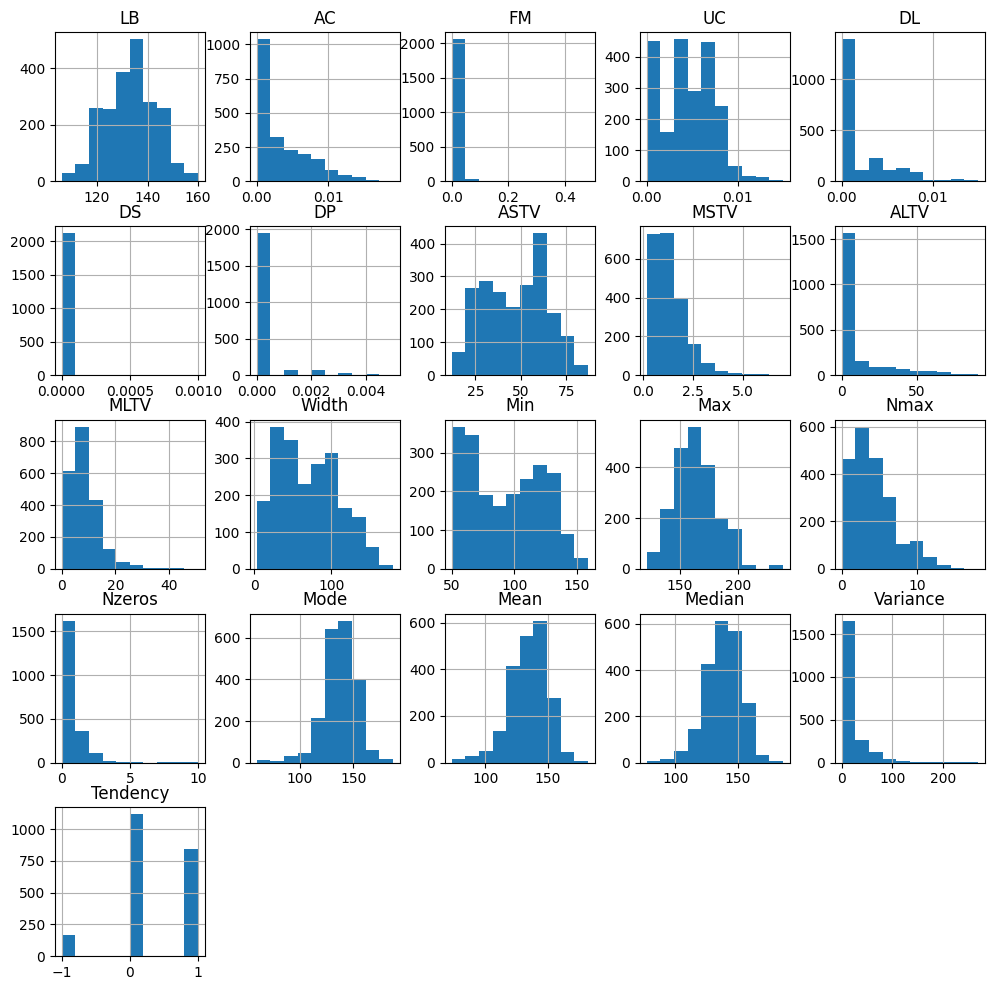

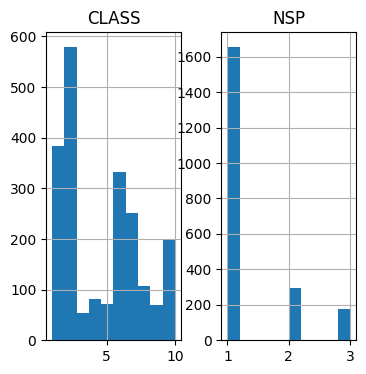

In [26]:
# Example: Plotting histograms of all numerical features
X.hist(figsize=(12, 12))
plt.show()

y.hist(figsize=(4, 4))
plt.show()


## Possible Biases


<Axes: xlabel='NSP', ylabel='count'>

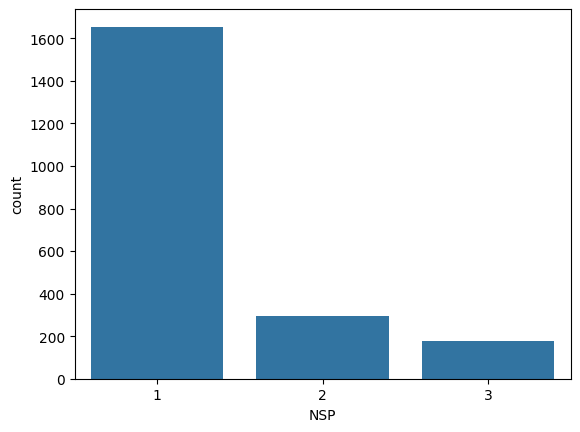

In [27]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here

#check for class imbalance
sns.countplot(x='NSP', data=y) # clear imbalance in the classes





## Correlation Analysis

[Explore correlations between features and the target variable, as well as among features themselves.]


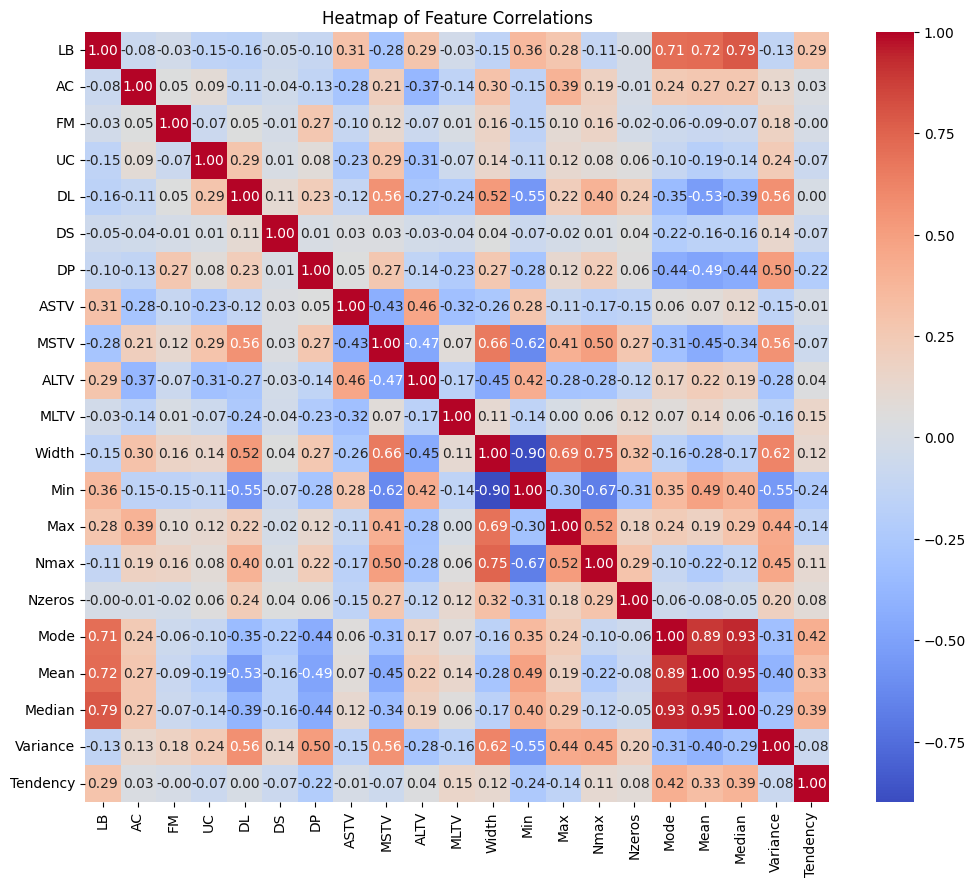

In [28]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot a heatmap to show feature correlations
plt.figure(figsize=(12, 10))  # Adjust the figure size to make it more readable
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Feature Correlations")
plt.show()


### Feature Selection with SelectKBest

SelectKBest is used to quickly identify the most relevant features based on their univariate relationship with the target variable. It is particularly helpful for initial feature screening because it ranks features by their statistical significance (e.g., using the ANOVA F-test).

       Specs       Score
6         DP  505.853206
9       ALTV  345.156385
7       ASTV  343.820419
17      Mean  297.625497
16      Mode  275.117696
18    Median  248.772237
1         AC  196.027523
19  Variance  150.796849
0         LB  140.621076
8       MSTV  119.882006


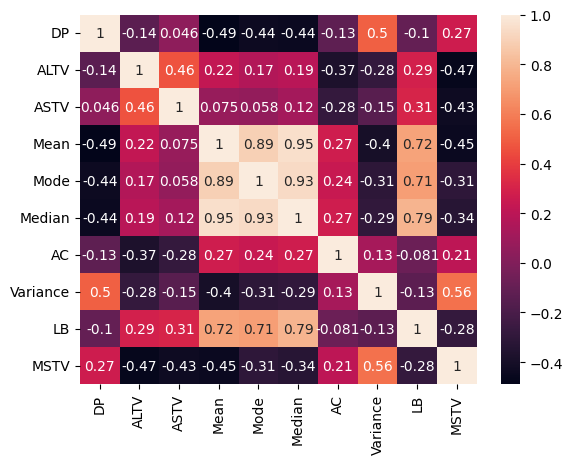

In [29]:
  ### Correlation of featurs with the target variable and feature selection

  # Feature selection
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  #apply SelectKBest class to extract top 10 best features --> highest discriminatory power
  bestfeatures = SelectKBest(score_func=f_classif, k=10)
  # Use the second column of y as the target variable, i.e. the NSP column
  fit = bestfeatures.fit(X, y.iloc[:, 1])
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X.columns)

  #concat two dataframes for better visualization
  featureScores = pd.concat([dfcolumns, dfscores], axis=1)
  featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
  print(featureScores.nlargest(10, 'Score'))  #print 10 best features

  # Select the top 10 features
  X_selected = X[featureScores.nlargest(10, 'Score')['Specs']]
  # selected featurs with highest discriminatory power are : DP  ALTV ASTV  Mean  Mode  Median  AC  Variance  LB  MSTV



  ####  correlation of the selected features

  # Plot the heatmap of the top 10 features
  correlation_matrix = X_selected.corr()
  sns.heatmap(correlation_matrix, annot=True)

  # RESULT
  #  certainly better readability. only very few of the selected features are highly correlated (e.g. >0.8).
  # These are : Mean, Mode and Median -->  expecteable. We should use only one of them in the model.

  # Drop the Mode and Median columns form the selected features
  X_selected = X_selected.drop(['Mode', 'Median'], axis=1)

### Random Forest Feature Importance

Random Forest Feature Importance is added to account for feature interactions and non-linear relationships that SelectKBest might miss. Unlike univariate methods, Random Forest evaluates the role of each feature within the context of the entire dataset. This allows us to capture features that may not be individually significant but contribute strongly when combined with others.

In [30]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Create 100 decision trees
rf.fit(X, y.iloc[:, 1])  # Target variable is the second column of y (NSP)

# Extract Feature Importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Features based on Random Forest Feature Importance:")
print(feature_importance_df.head(10))




Top 10 Features based on Random Forest Feature Importance:
   Feature  Importance
7     ASTV    0.133096
8     MSTV    0.130471
9     ALTV    0.121121
17    Mean    0.086454
16    Mode    0.061275
18  Median    0.056384
1       AC    0.048466
6       DP    0.048079
10    MLTV    0.043081
0       LB    0.038735


### Short description of the selected features

Based on the conducted analyses, the following features have been selected for further modeling and evaluation. These features were chosen using a combination of methods, including SelectKBest and Random Forest Feature Importance, to ensure the inclusion of both univariate significant features and those capturing complex interactions. The identified features show an almost complete overlap between the two methods, and therefore, the selection made by SelectKBest will be used moving forward.

In [31]:
# Define selected features, descriptions, and their data types
features_summary = {
    "DP": ["Prolonged decelerations", "Numerical"],
    "ALTV": ["Percentage of time with abnormal long-term variability", "Numerical"],
    "ASTV": ["Percentage of time with abnormal short-term variability", "Numerical"],
    "Mean": ["Histogram mean", "Numerical"],
    "AC": ["Accelerations (SisPorto)", "Numerical"],
    "Variance": ["Histogram variance", "Numerical"],
    "LB": ["Baseline value (SisPorto)", "Numerical"],
    "MSTV": ["Mean value of short-term variability (SisPorto)", "Numerical"]
}

# Convert to a DataFrame for better readability
features_df = pd.DataFrame(
    [(key, value[0], value[1]) for key, value in features_summary.items()],
    columns=["Feature", "Description", "Data Type"]
)

# Set pandas display options to show full width of the table
pd.set_option('display.max_colwidth', None)  # Ensure descriptions are fully visible
pd.set_option('display.width', 1000)        # Set table width for better display

# Save or display the DataFrame
print(features_df)


    Feature                                              Description  Data Type
0        DP                                  Prolonged decelerations  Numerical
1      ALTV   Percentage of time with abnormal long-term variability  Numerical
2      ASTV  Percentage of time with abnormal short-term variability  Numerical
3      Mean                                           Histogram mean  Numerical
4        AC                                 Accelerations (SisPorto)  Numerical
5  Variance                                       Histogram variance  Numerical
6        LB                                Baseline value (SisPorto)  Numerical
7      MSTV          Mean value of short-term variability (SisPorto)  Numerical


### Distributions of the selected features

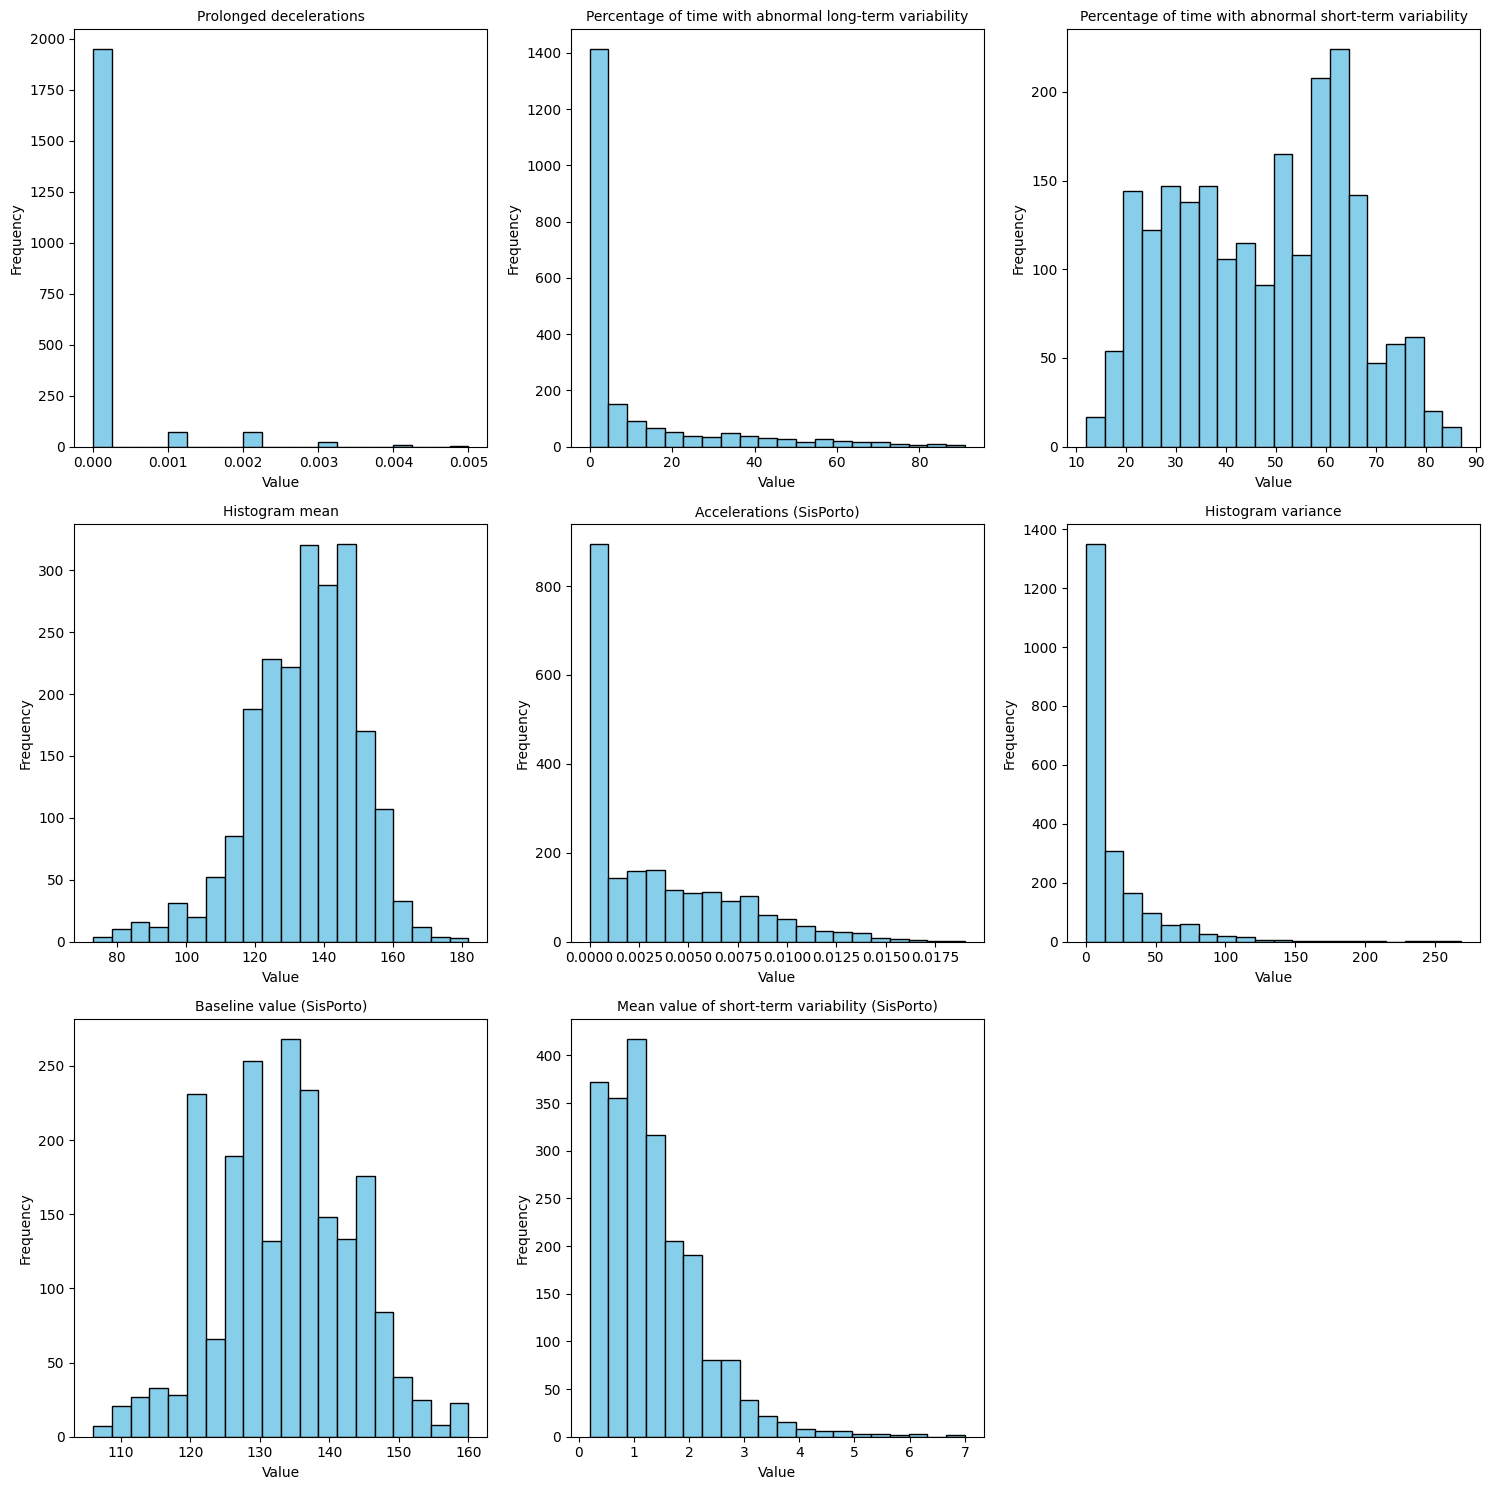

In [32]:
# Extract full variable names from features_summary
feature_names = {key: value[0] for key, value in features_summary.items()}

# Dynamically calculate the grid size for subplots based on the number of features
num_features = X_selected.shape[1]
num_rows = (num_features // 3) + (1 if num_features % 3 != 0 else 0)  # Rows needed for 3 plots per row

# Plot histograms with full variable names
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))  # Dynamically adjust grid size
axes = axes.ravel()  # Flatten the axes for easy iteration

for idx, column in enumerate(X_selected.columns):  # Iterate through all columns in X_selected
    ax = axes[idx]
    ax.hist(X_selected[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(feature_names.get(column, column), fontsize=10)  # Use full name if available, else column name
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide unused subplots if there are any
for i in range(num_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


## Outlier

#### Outlier Detection

In this section, we analyzed outliers in the dataset using two statistical methods: the IQR (Interquartile Range) and Z-scores.

**IQR Method:**

We identified variables with symmetric distributions (e.g., Mean and LB) and calculated the lower and upper boundaries based on the IQR.
Boxplots were created to visualize these variables, marking the IQR boundaries with vertical dashed lines. Data points outside these boundaries were flagged as potential outliers.

**Z-Score Method:**

For variables with asymmetrical distributions (e.g., DP, ALTV, AC, Variance, MSTV, ASTV), Z-scores were calculated.
Scatter plots were used to visualize the Z-scores, with horizontal dashed lines marking thresholds at ±3. Data points exceeding these thresholds were considered potential outliers.
Both methods allow us to systematically identify and evaluate outliers, which can help improve the quality and reliability of further data analysis.

##### IQR method and Z-Score method

In [33]:
# Function to detect outliers based on the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)  # First quartile (25%)
    Q3 = data.quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Lower boundary
    upper_bound = Q3 + 1.5 * IQR  # Upper boundary
    return lower_bound, upper_bound  # Return both boundaries


# Check for outliers in each feature using IQR
outlier_counts_iqr = X_selected.apply(detect_outliers_iqr)


# Calculate Z-scores for each feature
from scipy.stats import zscore
z_scores = zscore(X_selected, nan_policy='omit')  # Absolute Z-scores
z_scores_df = pd.DataFrame(z_scores, columns=X_selected.columns)  # Convert to DataFrame
outliers_zscore = (z_scores_df.abs() > 3).sum(axis=0)  # Count of outliers where Z > 3





In [34]:
# Function to detect outliers based on the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)  # First quartile (25%)
    Q3 = data.quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Lower boundary
    upper_bound = Q3 + 1.5 * IQR  # Upper boundary
    return (data < lower_bound) | (data > upper_bound)  # Boolean mask of outliers

# Check for outliers in each feature using IQR
outlier_counts_iqr = X_selected.apply(lambda col: detect_outliers_iqr(col).sum())  # Count of outliers

# Calculate Z-scores for each feature
from scipy.stats import zscore
z_scores = zscore(X_selected, nan_policy='omit')  # Absolute Z-scores
z_scores_df = pd.DataFrame(z_scores, columns=X_selected.columns)  # Convert to DataFrame
outliers_zscore = (z_scores_df.abs() > 3).sum(axis=0)  # Count of outliers where Z > 3

# Data: Number of outliers for each method and distribution descriptions
data = {
    "Feature": ["DP", "ALTV", "ASTV", "Mean", "AC", "Variance", "LB", "MSTV"],  # Only the final 8 features
    "Outliers (IQR)": outlier_counts_iqr.tolist(),
    "Outliers (Z-Score)": outliers_zscore.tolist(),
    "Distribution": [
        "Highly skewed to the right",
        "Strongly skewed to the right",
        "Uniform distribution with peaks",
        "Symmetrical, approximately normal",
        "Strongly skewed to the right",
        "Highly skewed to the right",
        "Symmetrical and bell-shaped",
        "Right-skewed distribution"
    ]
}

# Create a DataFrame
outlier_summary = pd.DataFrame(data)

# Display the DataFrame
print(outlier_summary)


    Feature  Outliers (IQR)  Outliers (Z-Score)                       Distribution
0        DP             178                 108         Highly skewed to the right
1      ALTV             309                  59       Strongly skewed to the right
2      ASTV               0                   0    Uniform distribution with peaks
3      Mean              45                  26  Symmetrical, approximately normal
4        AC              14                  23       Strongly skewed to the right
5  Variance             184                  44         Highly skewed to the right
6        LB               0                   0        Symmetrical and bell-shaped
7      MSTV              70                  33          Right-skewed distribution
